In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
import cv2
import h5py

In [ ]:
The dataset is taken from the udacity nano degree facial recognition project.

In [ ]:
hf1 = h5py.File('drive/My Drive/Facial Recognition/train_data_bw.h5', 'r')

hf1.keys()

x_train=hf1.get('x_train')
x_train=np.array(x_train)

y_train=hf1.get('y_train')
y_train=np.array(y_train)

hf1.close()




In [ ]:
hf2 = h5py.File('drive/My Drive/Facial Recognition/test_data_bw.h5', 'r')

hf2.keys()

x_test=hf2.get('x_test')
x_test=np.array(x_test)

y_test=hf2.get('y_test')
y_test=np.array(y_test)

hf2.close()

All the images in the dataset are black and white images.

In [ ]:
x_train=x_train.reshape(3462,200,200,1)
x_test=x_test.reshape(770,200,200,1)

The below functions and the classes are used for data augmentation. In this we apply Image Rescalig, ranfom cropping, horizontal and vertically shifting the image.

In [ ]:
#functions of data augmentation

def Rescale(n,size=200):
 
    x=n["x"]
    y=n["y"]
    image=n["image"] 


    x_pts=x
    y_pts=y
    
    h, w = image.shape[:2]
    
    new_h,new_w=size,size
    
    image=cv2.resize(image,(new_h,new_w))
    
    x_pts=x_pts*(new_w/w)
    y_pts=y_pts*(new_h/h)
    
    return {"image":image,"x":x_pts,"y":y_pts}




def h_flip(n):
    
    x=n["x"]
    y=n["y"]
    image=n["image"]

    h, w = image.shape[:2]
    x_pts=x
    y_pts=y
    
    image=cv2.flip(image,1)
    x_pts=w-x_pts
    y_pts=y_pts
    return {"image":image,"x":x_pts,"y":y_pts}
    
    
def v_flip(n):

    x=n["x"]
    y=n["y"]
    image=n["image"]
    
    h, w = image.shape[:2]
    x_pts=x
    y_pts=y
    
    image=cv2.flip(image,0)
    x_pts=x_pts
    y_pts=h-y_pts
    return {"image":image,"x":x_pts,"y":y_pts}


def hv_flip(n):
  i=np.random.randint(0,2)

  if(i==0):
    x=n["x"]
    y=n["y"]
    image=n["image"]
    
    h, w = image.shape[:2]
    x_pts=x
    y_pts=y
    
    image=cv2.flip(image,0)
    x_pts=x_pts
    y_pts=h-y_pts
    return {"image":image,"x":x_pts,"y":y_pts}

  else:
    x=n["x"]
    y=n["y"]
    image=n["image"]

    h, w = image.shape[:2]
    x_pts=x
    y_pts=y
    
    image=cv2.flip(image,1)
    x_pts=w-x_pts
    y_pts=y_pts
    return {"image":image,"x":x_pts,"y":y_pts}

      

    
def i_crop(n):

    x=n["x"]
    y=n["y"]
    image=n["image"]
    
    if (np.random.randint(-2,2)<0):
      return {"image":image,"x":x,"y":y}

    else:

      i=Rescale(n,size=np.random.randint(300,501))
      image1=i["image"]
      x_pts=i["x"]
      y_pts=i["y"]
      
      h, w = image1.shape[:2]
      new_h, new_w = 200,200

      top = np.random.randint(0, h - new_h)
      left = np.random.randint(0, w - new_w)

      image1 = image1[top: top + new_h,left: left + new_w]
      
      x_pts=x_pts-left
      y_pts=y_pts-top
      
      x_pts=np.fmax(0,x_pts)   #to remove the -ve values 
      y_pts=np.fmax(0,y_pts)
      
      return {"image":image1,"x":x_pts,"y":y_pts}


def h_shift(n):
    x=n["x"]
    y=n["y"]
    image=n["image"].reshape(200,200,1)
    
    h, w = image.shape[:2]
    x_shift=np.random.randint(-w/3,w/3)
    #x_shift=-34
    x_pts=x
    y_pts=y
    
    if(x_shift<=0):
        black=np.full((h,np.abs(x_shift),1),0.0)
        image1=np.hstack((image,black))
        
        image1=image1[0:h,np.abs(x_shift):np.abs(x_shift)+w]
        x_pts=np.array(x_pts)+x_shift
        y_pts=y_pts
        
        x_pts=np.fmax(0,x_pts)
        #y_pts=max(0,y_pts)
        
        return {"image":image1,"x":x_pts,"y":y_pts}
    
    else:
        black=np.full((h,np.abs(x_shift),1),0.0)
        black.shape
        image1=np.hstack((black,image))
        
        image1=image1[0:h,0:w]
        x_pts=np.array(x_pts)+x_shift
        y_pts=y_pts
        
        x_pts=np.fmin(w,x_pts)
        #y_pts=max(0,y_pts)
        
        return {"image":image1,"x":x_pts,"y":y_pts}


def v_shift(n):
    x=n["x"]
    y=n["y"]
    image=n["image"]
    
    h, w = image.shape[:2]
    y_shift=np.random.randint(-h/3,h/3)
    #x_shift=-34
    x_pts=x
    y_pts=y
    
    if(y_shift<=0): #image moves out of frmae frm top
        black=np.full((np.abs(y_shift),w,1),0.0)
        image1=np.vstack((image,black))
        
        image1=image1[np.abs(y_shift):np.abs(y_shift)+h,0:w]
        y_pts=np.array(y_pts)+y_shift
        x_pts=x_pts
        
        y_pts=np.fmax(0,y_pts)
        #y_pts=max(0,y_pts)
        
        return {"image":image1,"x":x_pts,"y":y_pts}
    
    else:
        black=np.full((np.abs(y_shift),w,1),0.0)
        black.shape
        image1=np.vstack((black,image))
        
        image1=image1[0:h,0:w]
        y_pts=np.array(y_pts)+y_shift
        x_pts=x_pts
        
        y_pts=np.fmin(h,y_pts)
        #y_pts=max(0,y_pts)
        
        return {"image":image1,"x":x_pts,"y":y_pts}


In [ ]:

class Augmentor:
  def __init__(self):
    self.funclist = list()
    self.add(lambda x: x)
  def __call__(self, num):
    #result =Rescale(num)
    result=num
    for each_func in self.funclist:
      result = each_func(result)
      #result = each_func(result)
    return result
  def add(self, func):
    self.funclist.append(func)
    

In [ ]:
a=Augmentor()

#a.add(Rescale)
#a.add(hv_flip)
a.add(i_crop)
a.add(h_shift)
a.add(v_shift)


In [ ]:
y_train=y_train*100+100.0

x_train1=np.copy(x_train)
y_train1=np.copy(y_train)



for i in np.arange(0,x_train.shape[0]):
  #n={"image":x_train[i],"x":y_train[i,0:68].reshape(1,68),"y":y_train[i,68:].reshape(1,68)}
  n={"image":x_train[i],"x":y_train[i,0:68].reshape(1,68),"y":y_train[i,68:].reshape(1,68)}

  r=a(n)

  x_train1[i]=(r["image"]).reshape(200,200,1)
  y_train1[i,0:68]=r["x"]
  y_train1[i,68:]=r["y"]

  
  #plt.imshow(r["image"])
  #plt.scatter(r["x"],r["y"])



y_train1=(y_train1-100.0)/100.0
y_train1.min()

y_train=(y_train-100.0)/100.0
y_train.max()

1.03

In [ ]:
y_train1.max()

2.50825

In [ ]:
#x_train2=np.copy(x_train1)
#y_train2=np.copy(y_train1)

x_train2=np.vstack((x_train2,x_train1))
y_train2=np.vstack((y_train2,y_train1))

In [ ]:
#create a model


input1=keras.layers.Input(shape=(200,200,1))

input1c=keras.layers.Concatenate()([input1,input1,input1])

dense_model=tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_tensor=input1c, input_shape=(200,200,3))
for l in dense_model.layers:
  l.trainable=True


i1=dense_model.output
m1=keras.layers.GlobalAveragePooling2D()(i1)

f=keras.layers.Flatten()(m1)

fc1=keras.layers.Dense(1024,activation='relu')(f)
fc2=keras.layers.Dense(512,activation='relu')(fc1)

output=keras.layers.Dense(136)(fc2)

model=keras.Model(inputs=input1, outputs=output)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 200, 200, 3)  0           input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 206, 206, 3)  0           concatenate_1[0][0]              
____________________________________________________________________________________________

In [ ]:
del x_train1,y_train1,x_train,y_train

In [ ]:
Early stopping and the reduce learning rate on plateau were used to save time on model training.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop,reduce_lr]

In [ ]:
model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.001))
history=model.fit(x_train2,y_train2,epochs=50,batch_size=10,validation_split=0.1,callbacks=callbacks_list)

Epoch 1/50
624/624 [==============================] - 141s 226ms/step - loss: 0.0081 - val_loss: 0.0206 - lr: 0.0010
Epoch 2/50
624/624 [==============================] - 139s 223ms/step - loss: 0.0060 - val_loss: 0.0159 - lr: 0.0010
Epoch 3/50
624/624 [==============================] - 139s 222ms/step - loss: 0.0064 - val_loss: 0.0242 - lr: 0.0010
Epoch 4/50
624/624 [==============================] - 139s 223ms/step - loss: 0.0137 - val_loss: 0.0192 - lr: 0.0010
Epoch 5/50
624/624 [==============================] - 139s 223ms/step - loss: 0.0076 - val_loss: 0.0164 - lr: 0.0010
Epoch 6/50
624/624 [==============================] - 139s 223ms/step - loss: 0.0056 - val_loss: 0.0145 - lr: 0.0010
Epoch 7/50
624/624 [==============================] - 139s 223ms/step - loss: 0.0052 - val_loss: 0.0154 - lr: 0.0010
Epoch 8/50
624/624 [==============================] - 139s 223ms/step - loss: 0.0054 - val_loss: 0.0184 - lr: 0.0010
Epoch 9/50
624/624 [==============================] - 139s 223ms

In [ ]:
e=model.evaluate(x_test,y_test)

25/25 [==============================] - 4s 151ms/step - loss: 0.0239


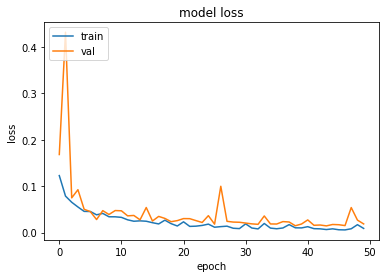

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
%whos

In [ ]:
def tester(i,model):
  image1=x_test[i]
  x=np.array([50,100])
  y=np.array([25,50])

  n={"image":image1,"x":x,"y":y}
  #n=Rescale(n)
  #n=h_shift(n)
  image1=n["image"].reshape(1,200,200,1)
  p=model.predict(image1)
  plt.imshow(image1[0][:,:,0],cmap='gray')
  p=p*100+100
  plt.scatter(p[0,0:68], p[0,68:])

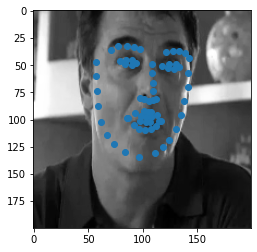

In [ ]:
i=200
tester(i,model)

In [ ]:
model.save('/content/facial_recognition_densenet.h5')

In [ ]:
model=tf.keras.models.load_model('drive/My Drive/facial_recognition_densenet.h5')